# 수거함 후보군 설정 - 지헌, 상은, 수민

### 0) 결정 상권과 카페가 동일 구역에 위치하는지 확인 - 상은, 수민

### 1) 초기 후보군 설정 - 상은, 수민
    * 1-1) 도로명 주소 데이터 사용, 카페 상권 근처의 좌표들을 초기 후보군으로 선정 - 24,889개
    * 1-2) 50m 안에 카페가 위치하는 좌표의 경우 반납이 용이하다고 가정하여 후보군에서 제외 
    * 1-3) 선정한 카페까지 최소 거리가 15분이 넘는 시간이 걸리는 경우, 수거함을 두기에는 너무 먼 지역이라고 판단하여 후보군에서 제외
    ==> 초기 후보군 약 4,618개
    
### 2) 후보군 지수 계산 - 지헌
    * 2-1) 각 후보군에 대하여 Feature 계산
        * (- = 적을수록 좋은 Feature)
        * -가장 가까운 버스 정류장까지의 거리
        * -가장 가까운 역 출구까지의 거리
        * (+ = 클수록 좋은 Feature)
        * +가장 가까운 대중교통 승차인원 수
        * +가장 가까운 카페까지의 거리
        * +500m 안의 대규모점포 관광거리 수
        * +500m 안의 공원이나 명소 수
    * 2-2) MinMaxScaler를 통해, 각 Feature를 Normalize
    * 2-3) 각 Feature를 더하거나 뺌으로써 각 후보군에 대한 후보군 Score 생성
    * 2-4) 후보군 Score의 평균 보고, 평균보다 낮은 값을 가지는 후보군을 제외
    
### 3) 후보군 Clustering : 위치가 너무 가까운 후보군의 경우를 clustering 하기 위함 - 지헌
    * 3-1) K-Means 사용하여 위치가 너무 가까운 후보군을 Clustering
    * 3-2) 각 Cluster의 중심점만 남기기


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import math
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po
import plotly.offline as pyo
import plotly.graph_objs as go

from pyproj import Proj, transform
import folium
from folium import plugins
from haversine import haversine
from sklearn.metrics import silhouette_samples


plt.rc('font', family='Malgun Gothic')
sns.set_style('darkgrid')
sns.set(font='Malgun Gothic')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
path = "../../데이터분석 공모전/2021 공공빅데이터 공모전/cup_sharing/"

## 0) 결정된 상권과 카페가 동일 구역에 존재하는지 확인.

In [3]:
cafe_clustered = pd.read_csv(path+"서울시카페클러스터링결과.csv")
comarea_nonclustered = pd.read_csv(path+"clustered_comarea(nonclustered_ver).csv")

In [4]:
gangnam = cafe_clustered[cafe_clustered['test4_label']==1]
gangnam_comarea = comarea_nonclustered[comarea_nonclustered['dbscan']==47]

In [190]:
g = go.Scatter(x=cafe_clustered["경도"],y=cafe_clustered["위도"], mode="markers",
               marker=dict(color='SkyBlue'))
g1 = go.Scatter(x=gangnam["경도"],y=gangnam["위도"], mode="markers", 
                marker=dict(color='Red'))
g2 = go.Scatter(x=gangnam_comarea["longitude"],y=gangnam_comarea["latitude"], mode="markers",
                opacity=0.4, marker=dict(color='Blue',size=10))
data = [g, g1, g2]
pyo.iplot(data)

# 1) 초기 후보군 설정
    * 1-1) 도로명 주소 데이터 사용, 카페 상권 근처의 좌표들을 초기 후보군으로 선정 - 24,889개
    * 1-2) 50m 안에 카페가 위치하는 좌표의 경우 반납이 용이하다고 가정하여 후보군에서 제외 
    * 1-3) 선정한 카페까지 최소 거리가 15분이 넘는 시간이 걸리는 경우, 수거함을 두기에는 너무 먼 지역이라고 판단하여 후보군에서 제외
    ==> 초기 후보군 약 4,618개

### 도로명주소 데이터 확인, 초기 후보군 선정

In [197]:
#도로명주소 데이터
add = open(path+"entrc_seoul.txt",encoding="cp949")
add_lines = add.readlines()

#주소와 위도 경도만 사용
candidates = pd.DataFrame([])
addresses = []
xs = []
ys = []

for line in add_lines:
    strs = line.replace("\n","").split("|")
    address = strs[3]+" "+strs[4]+" "+strs[5]+" "+strs[7]+" "+strs[9]+" "+strs[11]
    x = strs[16]
    y = strs[17]
    if x != "":
        addresses.append(address)
        xs.append(x)
        ys.append(y)

candidates['address'] = addresses
candidates['x'] = xs
candidates['y'] = ys

In [198]:
# 도로명주소는 epsg 5179 사용중이므로 변환
proj_1 = Proj(init='epsg:5179')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, candidates['x'].values, candidates['y'].values)
candidates['latitude'] = converted[1]
candidates['longitude'] = converted[0]

In [199]:
# 상권 근처의 후보군
candidates_gangnam = candidates[(candidates['longitude']>=127.03)&(candidates['longitude']<=127.085)]
candidates_gangnam = candidates_gangnam[(candidates_gangnam['latitude']>=37.48)&(candidates_gangnam['latitude']<=37.54)]

candidates_gangnam.drop("x",axis=1,inplace=True)
candidates_gangnam.drop("y",axis=1,inplace=True)

candidates_gangnam.head(3)

,address,latitude,longitude
71958,서울특별시 성동구 성수동1가 왕십리로 16 트리마제,37.539049,127.043970
72141,서울특별시 성동구 성수동1가 뚝섬로 356,37.539946,127.050286
72142,서울특별시 성동구 성수동1가 뚝섬로 358,37.539903,127.050475


초기 후보군:  24889


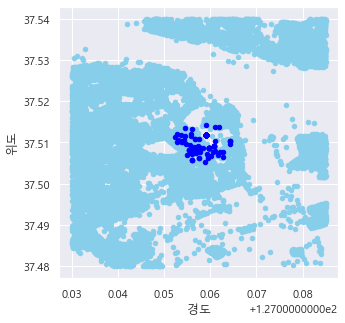

In [200]:
fig, ax = plt.subplots(figsize=(5,5))
candidates_gangnam.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
gangnam.plot.scatter(x='경도',y='위도',ax=ax,color='blue')
print("초기 후보군: ",len(candidates_gangnam))

In [253]:
haversine((37.54,127.0), (37.48,127.0))*1000

6671.704814012267

### 카페와 50m 근처에 있는, 반납이 용이한 후보군은 제외

In [201]:
addresses = []
lats = []
lons = []

for address,lat,lon in zip(candidates_gangnam['address'], candidates_gangnam['latitude'],candidates_gangnam['longitude']):
    in50m = False
    candidate = (lat, lon)
    for cafe_lat,cafe_lon in zip(gangnam['위도'],gangnam['경도']):
        cafe = (cafe_lat, cafe_lon)
        if haversine(candidate, cafe)*1000 <= 50: # 50m 
            in50m=True
            break
    
    if in50m == False:
        addresses.append(address)
        lats.append(lat)
        lons.append(lon)

In [202]:
candidates_far = pd.DataFrame([])
candidates_far['address']=addresses
candidates_far['latitude']=lats
candidates_far['longitude']=lons

현재 후보군:  24469


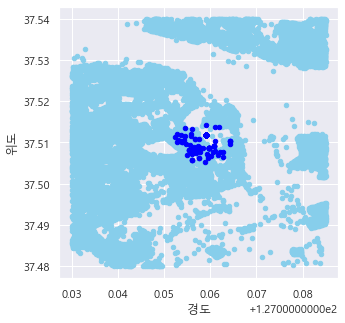

In [203]:
fig, ax = plt.subplots(figsize=(5,5))
candidates_far.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
gangnam.plot.scatter(x='경도',y='위도',ax=ax,color='blue')
print("현재 후보군: ",len(candidates_far))

### 카페와의 최소 거리가 15분 이상 걸리는 거리일 경우, 너무 먼 지역으로 판단. 후보군에서 제외

In [204]:
#카페와의 최소 거리 계산
distance_cafe = []

for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    candidate = (lat, lon)
    for cafe_lat,cafe_lon in zip(gangnam['위도'],gangnam['경도']):
        cafe = (cafe_lat, cafe_lon)
        if haversine(candidate, cafe)*1000 < minimum:
            minimum = haversine(candidate, cafe)*1000
    distance_cafe.append(minimum)

In [254]:
# 연령별 보행속도의 평균 구하기
walk = np.average([1.3,1.4,1.49,1.35,1.41,1.41,1.61,1.32])
walk

1.41125

In [206]:
# 15분보다 멀리 있는 후보군은 제외.
candidates_far['distance_cafe'] = distance_cafe
candidates_far=candidates_far[candidates_far['distance_cafe']<=(15*60*walk)]

현재 후보군:  5901


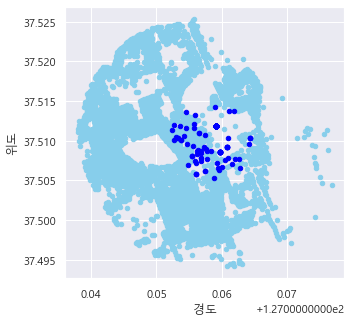

In [207]:
fig, ax = plt.subplots(figsize=(5,5))
candidates_far.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
gangnam.plot.scatter(x='경도',y='위도',ax=ax,color='blue')
print("현재 후보군: ",len(candidates_far))

# 2) 후보군 지수 계산 
   * 2-1) 각 후보군에 대하여 Feature 계산
        * (- = 적을수록 좋은 Feature)
        * -가장 가까운 버스 정류장까지의 거리
        * -가장 가까운 역 출구까지의 거리
        * (+ = 클수록 좋은 Feature)
        * +가장 가까운 대중교통 승차인원 수
        * +가장 가까운 카페까지의 거리
        * +500m 안의 대규모점포 관광거리 수
        * +500m 안의 공원이나 명소 수
   * 2-2) MinMaxScaler를 통해, 각 Feature를 Normalize
   * 2-3) 각 Feature를 더하거나 뺌으로써 각 후보군에 대한 후보군 Score 생성
   * 2-4) 후보군 Score의 평균 보고, 평균보다 낮은 값을 가지는 후보군을 제외


## 데이터 준비

### 버스정류장 데이터

In [208]:
#상권 근처의 버스 정류장만 추가.
bus_info = pd.read_csv(path+"서울특별시 버스정류소 위치정보.csv",encoding="cp949")
bus_gangnam = bus_info[(bus_info['X좌표']>=127.03)&(bus_info['X좌표']<=127.09)]
bus_gangnam = bus_gangnam[(bus_gangnam['Y좌표']>=37.48)&(bus_gangnam['Y좌표']<=37.54)]

In [209]:
#버스정류장 승차 인원 정보 추가
bus_ppl = pd.read_csv(path+"서울시 버스노선별 정류장별 시간대별 승하차 인원 정보.csv",encoding="cp949")
# bus_ppl['name'] = bus_ppl['사용년월'].astype(str)+"_"+bus_ppl['버스정류장ARS번호'].astype(str)

bus_ppl = bus_ppl[['사용년월','버스정류장ARS번호', '역명', '00시승차총승객수',
                   '1시승차총승객수', '2시승차총승객수', '3시승차총승객수', '4시승차총승객수', 
                   '5시승차총승객수', '6시승차총승객수', '7시승차총승객수', '8시승차총승객수',
                   '9시승차총승객수', '10시승차총승객수', '11시승차총승객수', '12시승차총승객수',
                   '13시승차총승객수', '14시승차총승객수', '15시승차총승객수', '16시승차총승객수',
                   '17시승차총승객수', '18시승차총승객수', '19시승차총승객수', '20시승차총승객수',
                   '21시승차총승객수', '22시승차총승객수', '23시승차총승객수']]

cols = ['00시승차총승객수','1시승차총승객수', '2시승차총승객수', '3시승차총승객수', '4시승차총승객수', 
        '5시승차총승객수', '6시승차총승객수', '7시승차총승객수', '8시승차총승객수', '9시승차총승객수',
        '10시승차총승객수', '11시승차총승객수', '12시승차총승객수', '13시승차총승객수', '14시승차총승객수',
        '15시승차총승객수', '16시승차총승객수', '17시승차총승객수', '18시승차총승객수', '19시승차총승객수',
        '20시승차총승객수', '21시승차총승객수', '22시승차총승객수', '23시승차총승객수']
bus_ppl['하루승차총승객수']= bus_ppl[cols].astype(int).sum(axis=1)

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [210]:
#버스 정류장 안의 모든 버스에 승차하는 하루 인원 (=하루 버스정류장 이용 인원 계산)
#사용년월과 버스정류장 번호로 groupby해서 사용. 
#데이터는 2020-08 부터 2021-09 까지, 가장 최신 것을 사용하도록 함.
bus_ppl_sum = bus_ppl[bus_ppl['버스정류장ARS번호'] != "~"].copy()
bus_ppl_sum['사용년월'] = bus_ppl_sum['사용년월'].astype(float).copy()
bus_ppl_sum['버스정류장ARS번호'] = bus_ppl_sum['버스정류장ARS번호'].astype(float).copy()
bus_ppl_sum=bus_ppl_sum[['사용년월','버스정류장ARS번호','하루승차총승객수']]
bus_ppl_sum=bus_ppl_sum.groupby(["사용년월","버스정류장ARS번호"]).sum().reset_index()
bus_ppl_sum=bus_ppl_sum.sort_values('사용년월',ascending=False)

nums = []
for num in bus_gangnam['정류소번호']:
    if len(bus_ppl_sum[bus_ppl_sum['버스정류장ARS번호']==num]) == 0:
        nums.append(-1)
    else:
        nums.append(bus_ppl_sum[bus_ppl_sum['버스정류장ARS번호']==num]['하루승차총승객수'][bus_ppl_sum[bus_ppl_sum['버스정류장ARS번호']==num].index[0]])

In [211]:
bus_gangnam['하루승차인원'] = nums
bus_gangnam=bus_gangnam[bus_gangnam['하루승차인원'] != -1]
bus_gangnam.head(3)

,정류소번호,정류소명,X좌표,Y좌표,하루승차인원
970,4171,성수1가1동새마을금고,127.049714,37.538156,1987
971,4172,성수1가새마을금고,127.049780,37.538171,10434
972,4173,천주교성수동성당앞,127.046409,37.539335,10199


### 지하철역 출구 데이터

In [212]:
subway_info = pd.read_csv(path+"지하철_역_정보.csv")
subway_exit = pd.read_csv(path+"지하철_역_출구_정보.csv")

#지하철 역 정보 데이터 사용해서, 지하철 역 출구 정보 데이터에 역 이름 추가
names =[]
exits = []
for subid, exit in zip(subway_exit['SBW_STATN_ID'], subway_exit['EXIT_NO']):
    subname = subway_info[subway_info['SBW_STATN_ID']==subid]['SBW_STATN_NM'][subway_info[subway_info['SBW_STATN_ID']==subid].index[0]]
    names.append(subname)
    exits.append(subname+" "+str(exit)+"번 출구")
    
subway_exit = subway_exit[['SBW_STATN_ID', 'EXIT_NO', 'SBW_STATN_XCRD', 'SBW_STATN_YCRD']].copy()
subway_exit['exit'] = exits
subway_exit['name'] = names

In [213]:
# 지하철 역 출구정보는, 네비게이션용 KATEC 좌표계(KOTI-KATEC)를 사용중임. 변환 필요
proj_1 = Proj('+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, subway_exit['SBW_STATN_XCRD'].values, subway_exit['SBW_STATN_YCRD'].values)
subway_exit['latitude'] = converted[1]
subway_exit['longitude'] = converted[0]

In [214]:
# 상권 근처의 지하철역 출구 만 추가.
subway_exits_gangnam = subway_exit[(subway_exit['longitude']>=127.03)&(subway_exit['longitude']<=127.09)]
subway_exits_gangnam = subway_exits_gangnam[(subway_exits_gangnam['latitude']>=37.48)&(subway_exits_gangnam['latitude']<=37.54)]

In [215]:
#지하철역 승차 인원 정보 추가
sub_ppl = pd.read_csv(path+"서울시 지하철 호선별 역별 시간대별 승하차 인원 정보.csv",encoding="cp949")
sub_ppl = sub_ppl[['사용월', '호선명', '지하철역', '04시-05시 승차인원', '05시-06시 승차인원',
                   '06시-07시 승차인원', '07시-08시 승차인원', '08시-09시 승차인원', '09시-10시 승차인원',
                   '10시-11시 승차인원', '11시-12시 승차인원', '12시-13시 승차인원',  '13시-14시 승차인원',
                   '14시-15시 승차인원', '15시-16시 승차인원', '16시-17시 승차인원', '17시-18시 승차인원',
                   '18시-19시 승차인원', '19시-20시 승차인원','20시-21시 승차인원', '21시-22시 승차인원',
                   '22시-23시 승차인원', '23시-24시 승차인원','00시-01시 승차인원', '01시-02시 승차인원',
                   '02시-03시 승차인원', '03시-04시 승차인원']]
cols = [ '04시-05시 승차인원', '05시-06시 승차인원', '06시-07시 승차인원', '07시-08시 승차인원', 
        '08시-09시 승차인원', '09시-10시 승차인원','10시-11시 승차인원', '11시-12시 승차인원',
        '12시-13시 승차인원',  '13시-14시 승차인원', '14시-15시 승차인원', '15시-16시 승차인원',
        '16시-17시 승차인원', '17시-18시 승차인원', '18시-19시 승차인원', '19시-20시 승차인원',
        '20시-21시 승차인원', '21시-22시 승차인원', '22시-23시 승차인원', '23시-24시 승차인원',
        '00시-01시 승차인원', '01시-02시 승차인원', '02시-03시 승차인원', '03시-04시 승차인원']
sub_ppl['하루승차총승객수']= sub_ppl[cols].astype(int).sum(axis=1)

In [216]:
#지하철역 승차 하루 인원 (=하루 지하철역 이용 인원 계산)
#사용년월과 역 이름으로 groupby해서 사용. 
#데이터는 2015-01 부터 2021-09 까지, 가장 최신 것을 사용하도록 함.
sub_ppl_sum = sub_ppl.copy()
sub_ppl_sum=sub_ppl_sum[['사용월','지하철역','하루승차총승객수']]
sub_ppl_sum=sub_ppl_sum.groupby(["사용월","지하철역"]).sum().reset_index()
sub_ppl_sum=sub_ppl_sum.sort_values('사용월',ascending=False)

names = []
for name in subway_exits_gangnam['name']:
    if len(sub_ppl_sum[sub_ppl_sum['지하철역']==name]) == 0:
        print(name)
    else:
        names.append(sub_ppl_sum[sub_ppl_sum['지하철역']==name]['하루승차총승객수'][sub_ppl_sum[sub_ppl_sum['지하철역']==name].index[0]])

In [259]:
subway_exits_gangnam['하루승차인원'] = names
subway_exits_gangnam[14:]

,SBW_STATN_ID,EXIT_NO,SBW_STATN_XCRD,SBW_STATN_YCRD,exit,name,latitude,longitude,하루승차인원
25,343,3,315889,543157,매봉 3번 출구,매봉,37.486733,127.046693,272114
26,343,4,315834,543128,매봉 4번 출구,매봉,37.486467,127.046074,272114
27,344,1,316615,543614,도곡 1번 출구,도곡,37.490916,127.054849,268926
28,344,2,316696,543655,도곡 2번 출구,도곡,37.491293,127.055761,268926
29,344,3,316707,543613,도곡 3번 출구,도곡,37.490915,127.055890,268926
...,...,...,...,...,...,...,...,...,...
4784,221,4,314884,544695,역삼 4번 출구,역삼,37.500498,127.035152,1017883
4785,221,5,315006,544740,역삼 5번 출구,역삼,37.500914,127.036526,1017883
4786,221,6,315016,544768,역삼 6번 출구,역삼,37.501167,127.036636,1017883
4787,221,7,315042,544767,역삼 7번 출구,역삼,37.501161,127.036930,1017883


### 대규모점포, 관광거리, 공원 데이터

In [218]:
#대규모 점포, 관광거리, 공원 정보
bigstores = pd.read_csv(path+"서울특별시 대규모점포 인허가 정보.csv",encoding="cp949")
tours = pd.read_csv(path+"서울시 관광거리 정보 (한국어).csv",encoding="cp949")
parks = pd.read_csv(path+"서울시 주요 공원현황.csv",encoding="cp949")

In [219]:
#대규모 점포
#폐업, 휴업 제외하고 영업하는 점포만 고려.
bigstores = bigstores[(bigstores['영업상태명'] == "영업/정상")]
bigstore_opened = bigstores[['사업장명', '최종수정일자', '데이터갱신구분','데이터갱신일자', '좌표정보(X)', '좌표정보(Y)']]
bigstore_opened=bigstore_opened[~bigstore_opened['좌표정보(X)'].isnull()]
bigstore_opened = bigstore_opened.groupby(["좌표정보(X)", "좌표정보(Y)"]).head(1)

In [261]:
# 대규모점포 정보는 epsg 2097 사용중이므로 변환
proj_1 = Proj(init='epsg:2097')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, bigstore_opened['좌표정보(X)'].values, bigstore_opened['좌표정보(Y)'].values)
bigstore_opened['latitude'] = converted[1]
bigstore_opened['longitude'] = converted[0]
bigstore_opened[['사업장명','latitude','longitude']][10:]

,사업장명,latitude,longitude
17,아이파크몰(I PARK MALL),37.529557,126.961267
18,세운스퀘어,37.572286,126.994173
19,동대문종합시장,37.570394,127.006022
24,청계상가,37.568048,126.992478
25,서울남대문시장,37.559213,126.974709
...,...,...,...
935,홈플러스(주)익스프레스 신정점,37.519168,126.850101
936,구의 자이르네 판매시설,37.545661,127.085647
937,홈플러스(주)익스프레스 면목점,37.584003,127.085168
938,홈플러스(주)면목점,37.579942,127.078154


In [221]:
#관광거리
tour = tours[['최종 표기명', '지번 주소', '중심 좌표 X','중심 좌표 Y']]
tour.columns = ['name', '지번 주소', 'longitude', 'latitude']
tour.head(3)

,name,지번 주소,longitude,latitude
0,서울신림동민속순대타운,서울시 관악구 서원동 일대,126.934598,37.463202
1,이대구제거리,서울시 서대문구 신촌동 일대,126.946546,37.561111
2,피맛골,서울시 종로구 종로1.2.3.4가동 일대,126.987380,37.574403


In [222]:
#공원
parks = parks[['공원명', 'X좌표(WGS84)', 'Y좌표(WGS84)']]
parks.columns = ['name','longitude','latitude']
parks.head(3)

,name,longitude,latitude
0,남산도시자연공원,126.990377,37.550140
1,길동생태공원,127.154779,37.540394
2,서울대공원,127.019846,37.426449


### 인구수 데이터

In [223]:
#행정동 코드정보 
add_info = pd.read_csv(path+"행정동코드_매핑정보_20200325.csv", encoding="cp949")

#현재 candidate들의 행정동 리스트
dongs = set([x.split(' ')[1] for x in candidates_gangnam['address']])
add_info = add_info[1:]

#candidates들의 행정동 코드 리스트
codes = add_info[add_info['시군구명'].isin(dongs)]['행자부행정동코드'].astype(int)
codes = list(set(codes))

#행정동 이름 - 코드 dict
add_info['구_동'] =add_info['시군구명'] + " " + add_info['행정동명']
dong_code = add_info[add_info['시군구명'].isin(dongs)]
dong_code = dict(set(zip(dong_code['행자부행정동코드'].astype(int),dong_code['구_동'])))

In [224]:
# #대규모 점포, 관광거리, 공원 정보
# for i in range(0,31):
#     ppl_info = pd.read_csv(path+"LOCAL_PEOPLE_202109/LOCAL_PEOPLE_202109"+i+".csv", encoding="cp949")
#     ppl_info
ppl_df = pd.DataFrame([])
for i in range(1,10):
    ppl_info = pd.read_csv(path+"LOCAL_PEOPLE_202109/LOCAL_PEOPLE_2021090"+str(i)+".csv", encoding="cp949")
    ppl_info = ppl_info[['?"기준일ID"', '행정동코드', '집계구코드', '총생활인구수']]
    ppl_info.columns = ['date', '행정동코드', '집계구코드', '총생활인구수']
    ppl_info = ppl_info[ppl_info['행정동코드'].isin(codes)]
    ppl_info = ppl_info.groupby(['date', '행정동코드', '집계구코드']).sum().reset_index()
    ppl_info.columns = ['date', '행정동코드', '집계구코드', '하루총생활인구수']
    if i==1:
        ppl_df = ppl_info.copy()
    else:
        ppl_df = pd.concat([ppl_df, ppl_info])

for i in range(10,31):
    ppl_info = pd.read_csv(path+"LOCAL_PEOPLE_202109/LOCAL_PEOPLE_202109"+str(i)+".csv", encoding="cp949")
    ppl_info = ppl_info[['?"기준일ID"', '행정동코드', '집계구코드', '총생활인구수']]
    ppl_info.columns = ['date', '행정동코드', '집계구코드', '총생활인구수']
    ppl_info = ppl_info[ppl_info['행정동코드'].isin(codes)]
    ppl_info = ppl_info.groupby(['date', '행정동코드', '집계구코드']).sum().reset_index()
    ppl_info.columns = ['date', '행정동코드', '집계구코드', '하루총생활인구수']
    ppl_df = pd.concat([ppl_df, ppl_info])

In [225]:
#한달 동안의 인구수 - 평균 취하기
ppl_df = ppl_df.groupby(['행정동코드','집계구코드']).mean().reset_index()
ppl_df = ppl_df[['행정동코드', '집계구코드', '하루총생활인구수']]

In [226]:
gu_dong = []
for code in ppl_df['행정동코드']:
    gu_dong.append(dong_code.get(code))
ppl_df['구_동'] = gu_dong

In [227]:
ppl_df.head(3)

,행정동코드,집계구코드,하루총생활인구수,구_동
0,11200520,1104052010001,964.636537,성동구 왕십리2동
1,11200520,1104052010002,10492.677460,성동구 왕십리2동
2,11200520,1104052010003,5134.097837,성동구 왕십리2동


## 각 후보군에 대하여 Feature 계산

In [228]:
candidates_far = candidates_far.copy()

In [229]:
#버스정류장과의 거리
distance_busstop = []
ppl_busstop =[] 
for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    ppl = 0
    num = 0
    candidate = (lat, lon)
    for bus_lat,bus_lon,bus_ppl in zip(bus_gangnam['Y좌표'],bus_gangnam['X좌표'],bus_gangnam['하루승차인원'].astype(int)):
        bus = (bus_lat, bus_lon)
        dist = haversine(candidate, bus)*1000
        if dist < minimum:
            minimum = dist
            ppl = bus_ppl
    distance_busstop.append(minimum)
    ppl_busstop.append(ppl)

candidates_far['distance_busstop'] = distance_busstop
candidates_far['ppl_busstop'] = ppl_busstop

In [230]:
#지하철역과의 거리
distance_subway = []
ppl_subway = []
for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    ppl=0
    num=0
    candidate = (lat, lon)
    for sub_lat,sub_lon,sub_ppl in zip(subway_exits_gangnam['latitude'],subway_exits_gangnam['longitude'], subway_exits_gangnam['하루승차인원']):
        sub = (sub_lat, sub_lon)
        dist = haversine(candidate, sub)*1000
        if dist < minimum:
            minimum = dist
            ppl=sub_ppl
    distance_subway.append(minimum)
    ppl_subway.append(ppl)
    
candidates_far['distance_subway'] = distance_subway
candidates_far['ppl_subway'] = ppl_subway

In [231]:
#500m 안에 있는 대규모 점포의 수
num_stores = []
for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    num = 0
    candidate = (lat, lon)
    for store_lat,store_lon in zip(bigstore_opened['latitude'],bigstore_opened['longitude']):
        store = (store_lat, store_lon)
        dist = haversine(candidate, store)*1000
        if dist <= 500:
            num+=1
    num_stores.append(num)

#500m 안에 있는 관광거리의 수
num_tours = []
for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    num=0
    candidate = (lat, lon)
    for tou_lat,tou_lon in zip(tour['latitude'],tour['longitude']):
        tou = (tou_lat, tou_lon)
        dist = haversine(candidate, tou)*1000
        if dist <= 500:
            num+=1
    num_tours.append(num)
    
#500m 안에 있는 공원 수
num_parks = []
for address,lat,lon in zip(candidates_far['address'], candidates_far['latitude'],candidates_far['longitude']):
    minimum = 1000000
    num=0
    candidate = (lat, lon)
    for par_lat,par_lon in zip(parks['latitude'],parks['longitude']):
        par = (par_lat, par_lon)
        dist = haversine(candidate, par)*1000
        if dist <= 500:
            num+=1
    num_parks.append(num)

candidates_far['num_storeandtour'] = np.add(np.add(num_tours,num_stores),num_parks)

In [232]:
#인구수 추가를 위해 동 합치기.
import re 
def remove(s): 
    remove_dong = re.compile('[0-9]동') 
    result = remove_dong.sub('', s)
    return(result)
def remove_dd(s): 
    remove_dong = re.compile('동+') 
    result = remove_dong.sub('', s)
    return(result)

ppl = ppl_df[['하루총생활인구수','구_동']].copy()
ppl['add'] = [remove(x)+"동" for x in ppl['구_동']]
ppl['add'] = [remove_dd(x+"동")+"동" for x in ppl['add']]
ppl['하루총생활인구수'] =ppl['하루총생활인구수'].astype(int)
ppl = ppl.groupby('add').sum()

In [262]:
ppl

,하루총생활인구수
add,
강남구 개포동,1137912
강남구 논현동,1900159
강남구 대치동,2668100
강남구 도곡동,1546517
강남구 삼성동,1692438
강남구 세곡동,1092131
강남구 수서동,549857
강남구 신사동,811893
강남구 압구정동,951941


In [233]:
#하루 인구수 추가
candidates_far['add'] = [x.split(" ")[1]+" "+x.split(" ")[2] for x in candidates_far['address']]

temp = []
for p in candidates_far['add'] :
    temp.append(ppl['하루총생활인구수'][p])
candidates_far['ppl'] = temp

result = candidates_far.drop('add',axis=1)
result.head(3)

,address,latitude,longitude,distance_cafe,distance_busstop,ppl_busstop,distance_subway,ppl_subway,num_storeandtour,ppl
8402,서울특별시 강남구 역삼동 언주로 407,37.499444,127.043984,1269.680762,33.508984,9347,604.793586,1017883,2,3415923
8403,서울특별시 강남구 역삼동 언주로 408 역삼자이,37.499507,127.044515,1229.857241,18.096942,9347,589.977594,1412321,2,3415923
8404,서울특별시 강남구 역삼동 언주로 409,37.499645,127.043860,1263.544007,30.476395,3443,590.131544,1017883,2,3415923


## Score 계산   
        * (- = 적을수록 좋은 Feature)
        * -가장 가까운 버스 정류장까지의 거리
        * -가장 가까운 역 출구까지의 거리
        * (+ = 클수록 좋은 Feature)
        * +가장 가까운 대중교통 승차인원 수
        * +가장 가까운 카페까지의 거리
        * +500m 안의 대규모점포 관광거리 수
        * +500m 안의 공원이나 명소 수
        * +하루총생활인구 수

In [234]:
#minmaxscaler
from sklearn.preprocessing import MinMaxScaler

set_feat = result[['distance_cafe', 'distance_busstop','ppl_busstop', 'distance_subway', 'ppl_subway', 'num_storeandtour','ppl']]
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(set_feat)
scaled_feat = pd.DataFrame(scaled_feat)

In [235]:
scaled_feat.head(3)

,0,1,2,3,4,5,6
0,0.999725,0.051311,0.097948,0.784648,0.676811,0.25,1.0
1,0.967083,0.020713,0.097948,0.765204,0.952245,0.25,1.0
2,0.994695,0.045290,0.034878,0.765406,0.676811,0.25,1.0


In [236]:
scaled_feat.columns = ['distance_cafe', 'distance_busstop','ppl_busstop', 'distance_subway', 'ppl_subway', 'num_storeandtour','ppl']
scaled_result = pd.concat([result.reset_index(drop=True)[['address', 'latitude', 'longitude']],scaled_feat.reset_index(drop=True)],axis=1)
scaled_result.head(3)

,address,latitude,longitude,distance_cafe,distance_busstop,ppl_busstop,distance_subway,ppl_subway,num_storeandtour,ppl
0,서울특별시 강남구 역삼동 언주로 407,37.499444,127.043984,0.999725,0.051311,0.097948,0.784648,0.676811,0.25,1.0
1,서울특별시 강남구 역삼동 언주로 408 역삼자이,37.499507,127.044515,0.967083,0.020713,0.097948,0.765204,0.952245,0.25,1.0
2,서울특별시 강남구 역삼동 언주로 409,37.499645,127.043860,0.994695,0.045290,0.034878,0.765406,0.676811,0.25,1.0


In [237]:
#Score 계산

scaled_result['score'] = scaled_result['distance_cafe']
                        +scaled_result['ppl_busstop']
                        +scaled_result['ppl_subway']
                        +scaled_result['ppl']
                        +scaled_result['num_storeandtour']
                        -scaled_result['distance_busstop']
                        -scaled_result['distance_subway']
                        
scaled_result.iloc[:,1:].head(3)

,latitude,longitude,distance_cafe,distance_busstop,ppl_busstop,distance_subway,ppl_subway,num_storeandtour,ppl,score
0,37.499444,127.043984,0.999725,0.051311,0.097948,0.784648,0.676811,0.25,1.0,2.188525
1,37.499507,127.044515,0.967083,0.020713,0.097948,0.765204,0.952245,0.25,1.0,2.481359
2,37.499645,127.043860,0.994695,0.045290,0.034878,0.765406,0.676811,0.25,1.0,2.145688


Mean: 1.0655085282455274
Median: 1.043801875849162
Min: -0.5297410206610741
Max: 2.845188874033496
Mid-range: 1.6874649473472851


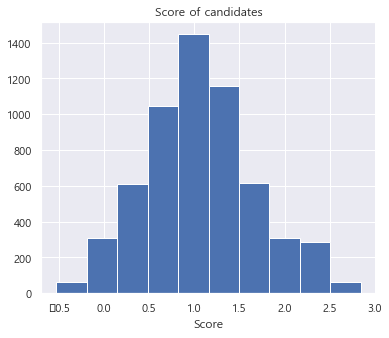

In [265]:
print("Mean:",np.mean(scaled_result['score']))
print("Median:",np.median(scaled_result['score']))
print("Min:",np.min(scaled_result['score']))
print("Max:",np.max(scaled_result['score']))
print("Mid-range:",(-np.min(scaled_result['score'])+np.max(scaled_result['score']))/2)

fig = plt.figure(figsize=(6,5))
plt.hist(scaled_result['score'])
plt.title("Score of candidates")
plt.xlabel("Score")
plt.show()

현재 후보군:  935


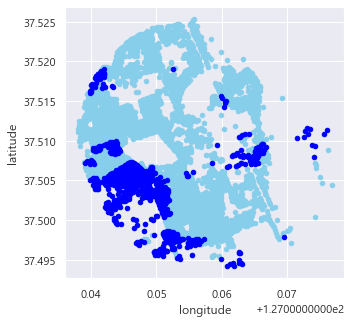

In [239]:
final_result = scaled_result[scaled_result['score']>1.65]

fig, ax = plt.subplots(figsize=(5,5))
candidates_far.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
final_result.plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
print("현재 후보군: ",len(final_result))                                                

# 3) 후보군 Clustering : 위치가 너무 가까운 후보군을 clustering 하기 위함
    * 3-1) K-Means 사용하여 위치가 너무 가까운 후보군을 Clustering
    * 3-2) 각 Cluster의 중심점만 남기기


In [267]:
print("클러스터링 전 후보군:",len(final_result))

클러스터링 전 후보군: 935


In [268]:
from sklearn.metrics import silhouette_score


In [269]:
ks = range(1,41)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(final_result[['latitude','longitude']])
    inertias.append(model.inertia_)

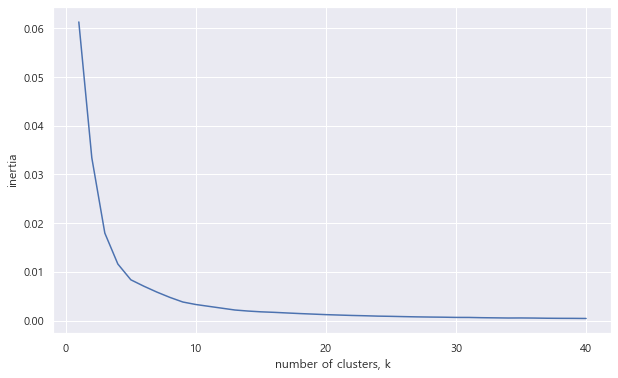

In [270]:
# Plot ks vs inertias
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(ks, inertias)
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks([0,10,20,30,40])
plt.show()

In [271]:
model = KMeans(n_clusters=10)
model.fit(final_result[['latitude','longitude']])
final_result['kmeans'] = model.labels_
centers = {x:y for x,y in model.cluster_centers_}
cluster_labels = model.fit_predict(final_result[['latitude','longitude']])
silhouette_avg = silhouette_score(final_result[['latitude','longitude']], cluster_labels)
print("실루엣:",silhouette_avg)
fig = px.scatter(final_result, 
                 title="result", 
                 x="longitude", 
                 y="latitude",
                 color = 'kmeans',
                width=700, height=500)
fig.show()

실루엣: 0.500763622738289


<ipython-input-271-82d6258e59cf>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
clustered_result = pd.DataFrame([])
clustered_result['latitude'] = centers.keys()
clustered_result['longitude'] = centers.values()

<AxesSubplot:xlabel='경도', ylabel='위도'>

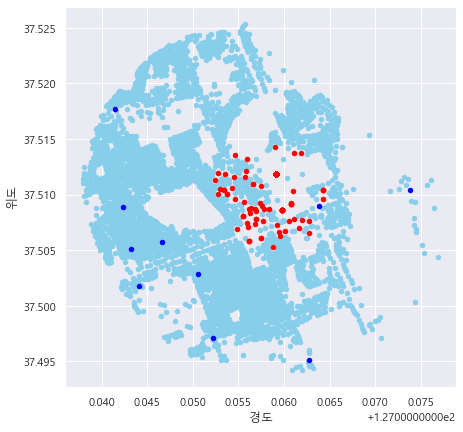

In [311]:
fig, ax = plt.subplots(figsize=(7,7))
candidates_far.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
clustered_result.plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
gangnam.plot.scatter(x='경도',y='위도',ax=ax,color='red')

In [455]:
temp_b = bigstore_opened[(bigstore_opened['longitude']>=127.03)&(bigstore_opened['longitude']<=127.09)]
temp_b = temp_b[(temp_b['latitude']>=37.495)&(temp_b['latitude']<=37.525)]

temp_t = tours[(tours['중심 좌표 X']>=127.03)&(tours['중심 좌표 X']<=127.09)]
temp_t = temp_t[(temp_t['중심 좌표 Y']>=37.495)&(temp_t['중심 좌표 Y']<=37.525)]
temp_p = parks[(parks['longitude']>=127.04)&(parks['longitude']<=127.08)]
temp_p = temp_p[(temp_p['latitude']>=37.495)&(temp_p['latitude']<=37.525)]

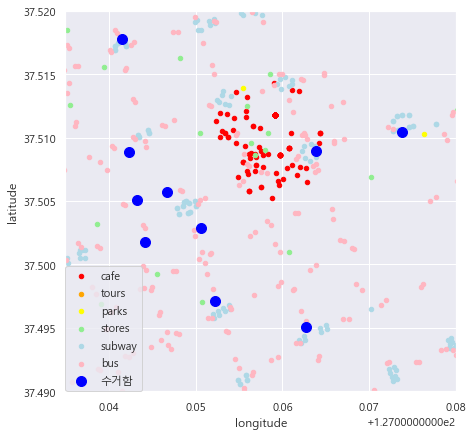

In [346]:
fig, ax = plt.subplots(figsize=(7,7))
gangnam.plot.scatter(x='경도',y='위도',ax=ax,color='red',label="cafe")
temp_t.plot.scatter(x='중심 좌표 X',y='중심 좌표 Y',ax=ax,color='orange',label="tours")
temp_p.plot.scatter(x='longitude',y='latitude',ax=ax,color='yellow',label="parks")
temp_b.plot.scatter(x='longitude',y='latitude',ax=ax,color='lightgreen',label="stores")
subway_exits_gangnam.plot.scatter(x='longitude',y='latitude',ax=ax,color='lightblue',label="subway")
bus_gangnam.plot.scatter(x='X좌표',y='Y좌표',ax=ax,color='lightpink',label="bus")
clustered_result.plot.scatter(x='longitude',y='latitude',s=100,ax=ax,color='blue',label="수거함")
plt.ylim(37.49,37.52)
plt.xlim(127.035,127.08)
plt.legend(loc=(0,0))
plt.show()

In [462]:
import folium

m = folium.Map(location=[37.5083, 127.0582], zoom_start=14.4)

In [463]:
for name,long,lat in zip(gangnam['상호명'],gangnam['경도'],gangnam['위도']):
    marker = folium.Marker([lat,long], popup=name,icon=folium.Icon(icon="star",color='red'))
    marker.add_to(m)
    
for long,lat in zip(clustered_result['longitude'],clustered_result['latitude']):
    marker = folium.Circle([lat,long],radius=500,color='blue',icon=folium.Icon(color='blue'))
    marker.add_to(m)   
    marker = folium.Marker([lat,long],icon=folium.Icon(color='blue'))
    marker.add_to(m)

# for long,lat in zip(bus_gangnam['X좌표'],bus_gangnam['Y좌표']):
#     marker = folium.Marker([lat,long],icon=folium.Icon(icon="car",color='green'))
#     marker.add_to(m)

# for long,lat in zip(subway_exits_gangnam['longitude'],subway_exits_gangnam['latitude']):
#     marker = folium.Marker([lat,long],icon=folium.Icon(icon="bus",color='orange'))
#     marker.add_to(m)
    
for name,long,lat in zip(temp_t['alias'],temp_t['중심 좌표 X'],temp_t['중심 좌표 Y']):
    marker = folium.Marker([lat,long], popup=name,icon=folium.Icon(icon="road",color='orange'))
    marker.add_to(m)
for name,long,lat in zip(temp_p['name'],temp_p['longitude'],temp_p['latitude']):
    marker = folium.Marker([lat,long], popup=name,icon=folium.Icon(icon="tree",color='orange'))
    marker.add_to(m)
for name,long,lat in zip(temp_b['사업장명'],temp_b['longitude'],temp_b['latitude']):
    marker = folium.Marker([lat,long], popup=name,icon=folium.Icon(icon="house",color='orange'))
    marker.add_to(m)
    


In [464]:
m

In [441]:
m